In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", 
            "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cf4b7f5b-83ea-4360-ac1e-4cd9940c7856;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-834346005548/project/submissions/yyyy=*


23/12/06 20:37:15 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/12/06 20:37:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 3.45 s, sys: 252 ms, total: 3.7 s
Wall time: 6min 34s


In [6]:
topcreators= pd.read_csv('../../data/csv/Top100Creators.csv')
topcreators= topcreators['author'].tolist()
topcreators = list(set(topcreators))

In [8]:
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_

In [9]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline

In [10]:
from pyspark.sql.functions import length

In [11]:
submissions_var= submissions.withColumn("created_hour",F.hour(F.to_timestamp(F.col("created_utc").cast('int'))))\
                                            .withColumn('text_length',F.length(F.col('selftext')))\
                                            .withColumn("title_length", length(col("title")))\
                                            .withColumn("is_top_100_creator", col("author").isin(topcreators))\
                                            .withColumn("is_peak_hour", col("created_hour").isin([16, 17, 18, 19, 20, 21, 22, 23, 0]))\
                                            .withColumn("has_media", col("media").isNotNull() | col("media_embed").getField('content').isNotNull())\
                                            .withColumn("is_long_text",(F.col('text_length') > 200))


# Dummy submissions varaibles
submissions_var= submissions_var.withColumn("skincare",F.col("selftext").rlike("""(?i)body|(?i)hair|(?i)facial|(?i)nails|(?i)lip|(?i)sunscreen|(?i)SPF|(?i)acne|(?i)pimples|(?i)scar|(?i)aging"""))\
                                  .withColumn("skincare_product",F.col("selftext").rlike("""(?i)moisturizer|(?i)cleanser|(?i)serum|(?i)toner|(?i)lotion"""))\
                                  .withColumn("skincare_product_brand",F.col("selftext").rlike("""(?i)Clinique|(?i)Neutrogena|(?i)Cetaphil|(?i)Kiehl's|(?i)Olay"""))\
                                  .withColumn("makeup",F.col("selftext").rlike("""(?i)beauty|(?i)bodypaint|(?i)cosmetics|(?i)style|(?i)artist|(?i)cosplay|(?i)fashion|(?i)celebrity|(?i)party|(?i)wedding|(?i)palette"""))\
                                  .withColumn("makeup_product",F.col("selftext").rlike("""(?i)eyeliner|(?i)contour|(?i)foundation|(?i)blush|(?i)lipstick|(?i)concealer"""))\
                                  .withColumn("makeup_product_brand",F.col("selftext").rlike("""(?i)MAC|(?i)NARS|(?i)Sephora|(?i)Fenty|(?i)Revlon|(?i)NYX|(?i)L'Oreal|(?i)Maybelline"""))


In [12]:
# List of columns to select as independent variables
independent_vars = [
    "is_top_100_creator", "text_length", "title_length", "archived", "is_peak_hour", "gilded", "hidden", "hide_score", "is_crosspostable",
    "is_reddit_media_domain", "is_self", "is_video", "num_crossposts", "over_18", "has_media", "pinned", "score",
    "spoiler", "stickied", "is_long_text", "skincare",
    "skincare_product", "skincare_product_brand", "makeup", "makeup_product",
    "makeup_product_brand","num_comments"
]

# Selecting the independent variables from the DataFrame
selected_df = submissions_var.select(independent_vars)

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [14]:
feature_columns = [col for col in selected_df.columns if col not in ['num_comments']]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [15]:
# Split the data into training and test sets
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=123)

In [16]:
feature_columns = [col for col in selected_df.columns if col not in ['num_comments']]

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a Gradient Boosted Tree Regressor model
gbt = GBTRegressor(featuresCol="features", labelCol="num_comments", seed=123)

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model = pipeline.fit(train_data)


In [17]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [44]:
# Evaluate the model using RMSE
rmse_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="rmse")
gbt_rmse = rmse_evaluator.evaluate(predictions)
print(f"RMSE: {gbt_rmse}")

# Evaluate the model using R2
r2_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="r2")
gbt_r2 = r2_evaluator.evaluate(predictions)
print(f"R2: {gbt_r2}")

# Evaluate the model using MAE
mae_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="mae")
gbt_mae = mae_evaluator.evaluate(predictions)
print(f"MAE: {gbt_mae}")

RMSE: 39.32078949645276


R2: 0.35420199863450674


MAE: 7.42157799161808


In [19]:
from pyspark.ml.regression import LinearRegression

# Define a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="num_comments")

# Create a Pipeline
lr_pipeline = Pipeline(stages=[assembler, lr])

# Train the model
lr_model = lr_pipeline.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)
print(f"Linear Regression - RMSE: {lr_rmse}, R2: {lr_r2}, MAE: {lr_mae}")


23/12/05 21:37:30 WARN Instrumentation: [4b9d6b10] regParam is zero, which might cause numerical instability and overfitting.
23/12/05 21:39:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/12/05 21:39:54 WARN Instrumentation: [4b9d6b10] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Linear Regression - RMSE: 98.10275621467068, R2: 0.2937501602353928, MAE: 8.502292652599


In [39]:
from pyspark.ml.regression import RandomForestRegressor

# Define a Random Forest Regressor model with specific parameters
rf = RandomForestRegressor(featuresCol="features",labelCol="num_comments",seed=123)
# Create a Pipeline
rf_pipeline = Pipeline(stages=[assembler, rf])

# Train the model
rf_model = rf_pipeline.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)
rmse_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="mae")

# Evaluate the model
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
print(f"Random Forest - RMSE: {rf_rmse}, R2: {rf_r2}, MAE: {rf_mae}")



Random Forest - RMSE: 36.37996771881387, R2: 0.3972837164739184, MAE: 7.12384739487361


In [20]:
from pyspark.ml.regression import RandomForestRegressor

# Define a Random Forest Regressor model with specific parameters
rf = RandomForestRegressor(featuresCol="features",labelCol="num_comments",seed=123)
# Create a Pipeline
rf_pipeline = Pipeline(stages=[assembler, rf])

# Train the model
rf_model = rf_pipeline.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)
rmse_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="mae")

# Evaluate the model
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
print(f"Random Forest - RMSE: {rf_rmse}, R2: {rf_r2}, MAE: {rf_mae}")



Random Forest - RMSE: 112.11912418948454, R2: 0.07752344488483764, MAE: 7.90874190808564


In [21]:
# Generalized Linear Regression
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(featuresCol="features", labelCol="num_comments", family="gaussian", link="identity")
glr_pipeline = Pipeline(stages=[assembler, glr])
glr_model = glr_pipeline.fit(train_data)
glr_predictions = glr_model.transform(test_data)
# Evaluate the model
glr_rmse = rmse_evaluator.evaluate(glr_predictions)
glr_r2 = r2_evaluator.evaluate(glr_predictions)
glr_mae = mae_evaluator.evaluate(glr_predictions)
print(f"Generalized Linear Regression - RMSE: {glr_rmse}, R2: {glr_r2}, MAE: {glr_mae}")

23/12/05 22:11:23 WARN Instrumentation: [9dbadc78] regParam is zero, which might cause numerical instability and overfitting.
23/12/05 22:14:06 WARN Instrumentation: [9dbadc78] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Generalized Linear Regression - RMSE: 98.10275621467068, R2: 0.2937501602353929, MAE: 8.502292652599001


In [22]:
# Elastic Net Regression
elastic_net = LinearRegression(featuresCol="features", labelCol="num_comments", elasticNetParam=0.8, regParam=0.1, maxIter=10, fitIntercept=True, standardization=True)
elastic_net_pipeline = Pipeline(stages=[assembler, elastic_net])
elastic_net_model = elastic_net_pipeline.fit(train_data)
elastic_net_predictions = elastic_net_model.transform(test_data)
# Evaluate the model
en_rmse = rmse_evaluator.evaluate(elastic_net_predictions)
en_r2 = r2_evaluator.evaluate(elastic_net_predictions)
en_mae = mae_evaluator.evaluate(elastic_net_predictions)
print(f"Elastic Net Regression - RMSE: {en_rmse}, R2: {en_r2}, MAE: {en_mae}")

Elastic Net Regression - RMSE: 98.17368304307564, R2: 0.29272857488884796, MAE: 8.447160226085387


In [46]:
import pandas as pd
import plotly.graph_objects as go


metrics_data = {
    "Model": ["Generalized Linear Regression", "Elastic Net Regression","Random Forest", "Gradient Boosted Tree Regressor","Linear Regression"],
    "RMSE": [glr_rmse, en_rmse,rf_rmse, gbt_rmse,lr_rmse],
    "R2": [glr_r2,en_r2,rf_r2, gbt_r2,lr_r2],
    "MAE": [glr_mae, en_mae,rf_mae, gbt_mae,lr_mae]
}

# Convert the metrics data into a Pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

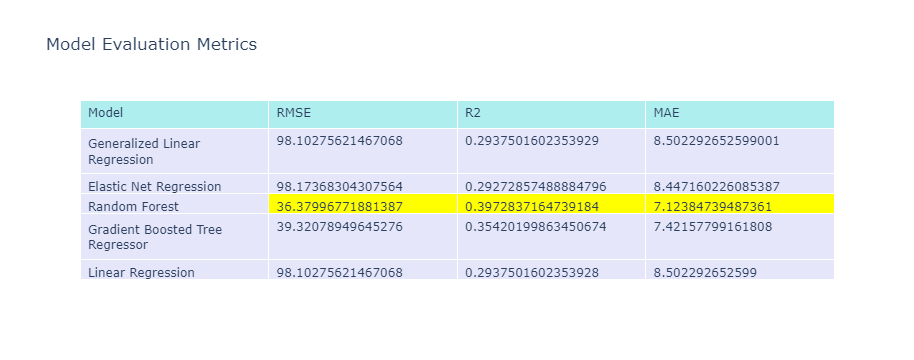

In [47]:
# Create a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(metrics_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[metrics_df.Model, metrics_df.RMSE, metrics_df.R2, metrics_df.MAE],
               fill=dict(color=['lavender',  # Cells color for Model column
                               ['yellow' if val == min(metrics_df.RMSE) else 'lavender' for val in metrics_df.RMSE],
                               ['yellow' if val == max(metrics_df.R2) else 'lavender' for val in metrics_df.R2],
                               ['yellow' if val == min(metrics_df.MAE) else 'lavender' for val in metrics_df.MAE]]),
               align='left'))
])

fig.update_layout(title_text='Model Evaluation Metrics')

# Show the figure
fig.show()

In [48]:
fig.write_html("num_comments_model_metrics.html")

From a technical standpoint, the Random Forest model exhibits outstanding performance in our model evaluation, achieving the lowest RMSE of approximately 36.38, the highest R2 value of roughly 0.397, and a low MAE near 7.12. This model demonstrates a strong capacity to capture the underlying variability within the data, suggesting a robust fit capable of delineating the complex, non-linear patterns often present in social media user interactions. In comparison, the Gradient Boosted Tree Regressor, while also effective, does not quite match the Random Forest in terms of the R2 metric. The Generalized Linear and Linear Regression models post identical RMSE and R2 values, indicating a potentially oversimplified approach to modeling the intricate data landscape. Elastic Net Regression, with a slight improvement in R2, still falls short of the tree-based methodologies.

From a business perspective, the superior results of the Random Forest model highlight its reliability for predicting user engagement within the "MakeupAddiction" subreddit. Its high degree of accuracy offers moderators and marketers actionable insights for anticipating engagement patterns, gearing up for trending discussions, and developing resonant content. Although the Gradient Boosted Tree also shows promise, the Random Forest's nuanced modeling makes it particularly valuable for informing strategic decisions. Conversely, the limited performance of the linear models may not adequately cater to the nuanced and dynamic nature of online social interactions, which could lead to less effective engagement strategies. Harnessing the Random Forest insights could lead to more compelling content creation, strategic planning for user interaction, and overall heightened community activity.

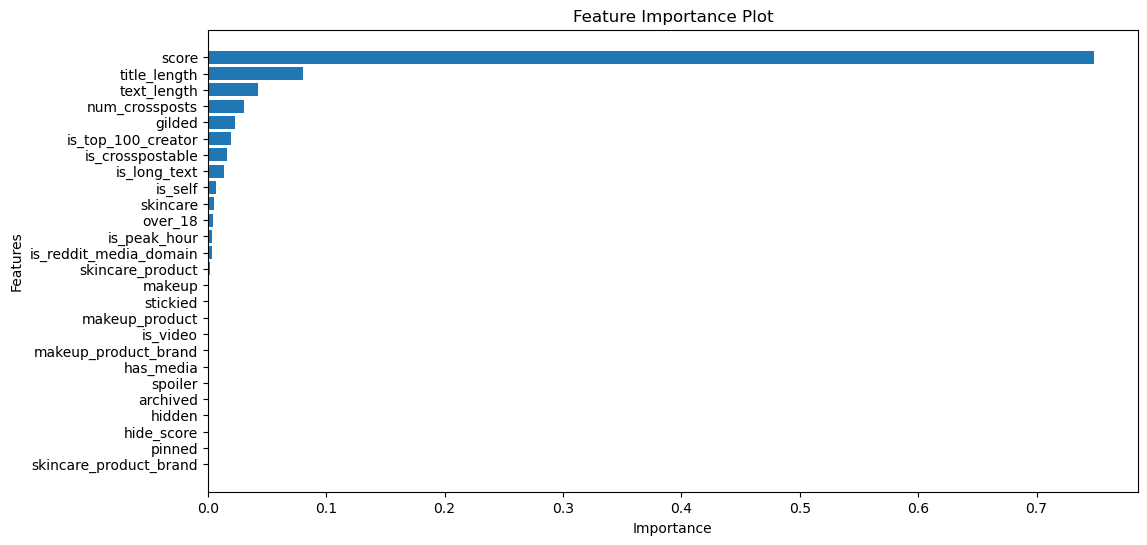

In [30]:
import matplotlib.pyplot as plt

# Extract the RandomForestRegressor model from the pipeline
rf_stage = rf_model.stages[-1]  # The last stage is the RandomForestRegressor

# Extract feature importances from the RandomForestRegressor model
feature_importances = rf_stage.featureImportances.toArray()

# Get feature names from the VectorAssembler
# which is the VectorAssembler used in the pipeline
feature_names = assembler.getInputCols()

# Match feature names with their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importances = [x[1] for x in sorted_features]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


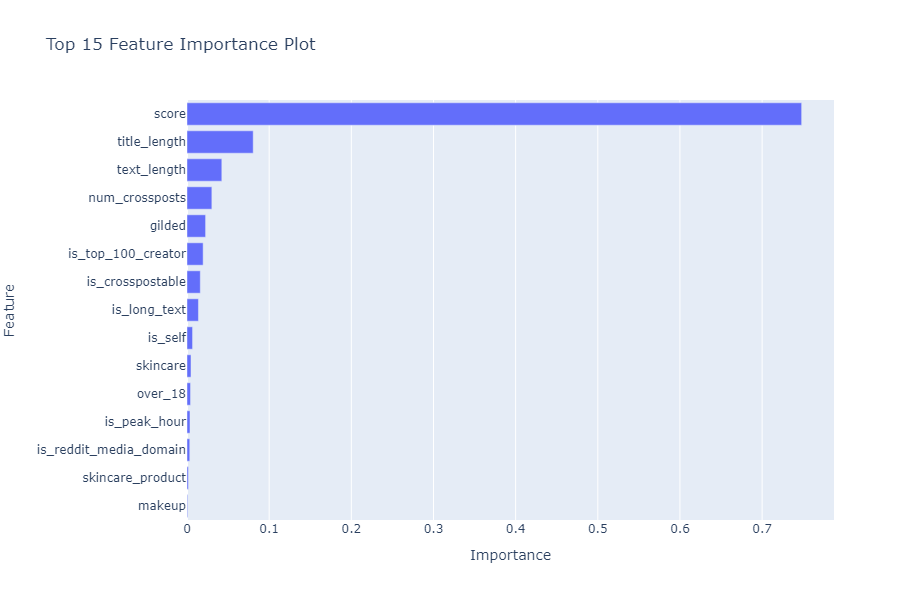

In [31]:
# Convert the dictionary to a DataFrame
feature_importances_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])
feature_importances_df.sort_values('Importance', ascending=True, inplace=True)

top_15_features_df = feature_importances_df.sort_values('Importance', ascending=False).head(15)

# Create a Plotly bar chart for the top 15 features
fig = px.bar(
    top_15_features_df, 
    x='Importance', 
    y='Feature', 
    orientation='h',
    title='Top 15 Feature Importance Plot'
)

# Reverse the y-axis to show the most important feature at the top
fig.update_layout(yaxis={'categoryorder':'total ascending'})

# Adjust the layout to fit the feature names and enhance readability
fig.update_layout(
    margin=dict(l=160),  # Increase left margin to fit longer feature names
    height=600,  # Adjust height to fit top 15 features
    width=900   # Optionally adjust width to your preference
)

# Show the plot
fig.show()

In [33]:
fig.write_html("num_comments_top15_feature_importance.html")

Fig 3 illustrates the key drivers of user engagement on the "MakeupAddiction" subreddit, informed by a Random Forest machine learning model's feature importance analysis. The 'score' emerges as the most influential factor, underscoring the importance of content that resonates with the community in fostering discussion. The length of the title also proves to be significant, highlighting the impact of a concise and engaging title in capturing user attention.

The model points to crossposting, the presence of a 'top creator', and text length as significant predictors of engagement, suggesting that visibility across communities, creator reputation, and detailed content are valued by the subreddit's users. Timing (indicated by 'is_peak_hour') and content hosting (suggested by 'is_reddit_media_domain') are also important, emphasizing when and where content is posted as factors in maximizing user interaction. Moreover, the interest in skincare topics suggests a broader community engagement beyond makeup alone, while preferences for posts with media and narrative ('is_self' and 'is_long_text') indicate a fondness for visually appealing and story-rich content.

From a business intuition perspective, this plot reveals the intricate dynamics of user engagement within the "MakeupAddiction" subreddit, showcasing the most influential factors that lead to a submission garnering comments. From it, we can glean actionable suggestions for crafting content that not only captivates the audience but also encourages vibrant discussions. 

Quality is the cornerstone of any successful submission. The 'score' of a post, as seen leading our list, is a tangible measure of the community's response, acting as a direct indicator of the content's resonance with the audience. Achieving a high score entails crafting posts that are both visually and informatively engaging—high-resolution images, thorough tutorials, and authentic reviews are the kind of content that often sees a positive reception. 

The art of titling is your gateway to capturing immediate interest. A title that succinctly yet vividly encapsulates the essence of your content can make the difference between a fleeting glance and a deep dive into your post. It's the spark that ignites curiosity and engagement, making it a crucial element in the anatomy of a popular submission.

Crossposting strategically serves to broaden the reach of your content, inviting new perspectives and discussions from various corners of the Reddit world. It's a nod to the interconnectedness of communities and interests, which can be a powerful tool in amplifying the voice of your submission. Moreover, becoming a familiar figure in the subreddit through regular, quality contributions can elevate your content's visibility and the engagement it receives—our plot suggests that being recognized as a top creator has its perks.

The plot also underscores the importance of content depth. A lengthy, well-articulated post can spark extensive discussions, inviting users to engage with the content and each other. This depth can be achieved through storytelling, comprehensive guides, or detailed personal experiences, which often encourage users to contribute their insights and extend the conversation.

Understanding the subreddit's rhythms and posting during peak hours can significantly increase the chances of your content being seen and engaged with. It's about being present in the community's space when they are most active and eager for new content. And when it comes to hosting media, remember that content hosted directly on Reddit's media domain can offer a smoother user experience, leading to better engagement. 

Expanding the content's focus to include discussions about skincare, in addition to makeup, can also invite a broader spectrum of comments. It's a recognition of the holistic approach the community often takes towards beauty routines. And while visual content is key in a makeup-centric space, do not underestimate the power of a good story. Narrative-driven 'self' posts can resonate deeply with readers, prompting them to engage in a more personal and meaningful way.

By weaving together these insights—focusing on content quality, mastering the craft of titling, leveraging cross-community interest through strategic crossposting, engaging consistently as a creator, enriching the narrative depth of your posts, timing your content right, and using the platform's media hosting effectively—you can create posts that are not just seen but talked about. This plot serves as a roadmap to navigating the "MakeupAddiction" subreddit, helping you to foster a submission that has the potential to spark a lively and lasting dialogue.

In [34]:
from pyspark.ml import PipelineModel
model_path = "num_comments_rf_model"  

# Save the model
rf_model.write().overwrite().save(model_path)


In [49]:
from pyspark.ml import PipelineModel

# Path where the model is saved
model_path = "num_comments_rf_model"  # Use the same path as before

# Load the saved model
loaded_rf_model = PipelineModel.load(model_path)

# Make predictions using the loaded model
loaded_rf_predictions = loaded_rf_model.transform(test_data)

# Evaluate the predictions
rmse_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="num_comments", predictionCol="prediction", metricName="mae")

# Calculate evaluation metrics
loaded_rf_rmse = rmse_evaluator.evaluate(loaded_rf_predictions)
loaded_rf_r2 = r2_evaluator.evaluate(loaded_rf_predictions)
loaded_rf_mae = mae_evaluator.evaluate(loaded_rf_predictions)

# Print the evaluation metrics
print(f"Loaded Random Forest Model - RMSE: {loaded_rf_rmse}, R2: {loaded_rf_r2}, MAE: {loaded_rf_mae}")


Loaded Random Forest Model - RMSE: 39.37996771881387, R2: 0.3972837164739184, MAE: 7.12384739487361
